# CARREGAMENTO DO MODELO PARA OS CASOS CONFIRMADOS

#### IMPORTAÇÕES

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
from pickle import load

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# IMPORT REDES NEURAIS
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler

#### FUNÇÕES

In [2]:
def get_fac2(y_true, y_pred):
    min_ = 0.5
    max_ = 2
    
    eps = np.finfo(np.float).eps
    
    division = y_pred / (y_true+eps)
    
    greater_min = np.greater_equal(division, min_)
    less_max = np.less_equal(division, max_)

    res = np.equal(greater_min, less_max)
    res = res.astype(float)

    fac_2 = res.mean()

    return fac_2

In [3]:
def get_metrics(y_true, y_pred):
    
    metrics = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'Pearson r', 'Fac2'])
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        y_true_col = y_true.iloc[:, col]
        y_pred_col = y_pred.iloc[:, col]

        if y_true_col.name == y_pred_col.name:
            col_name = y_true_col.name
        else:
            print('Column name error.')
            return None

        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = mean_squared_error(y_true_col, y_pred_col, squared=False)
        mae = mean_absolute_error(y_true_col, y_pred_col)
        pearson_r = pearsonr(y_true_col, y_pred_col)[0]
        fac2 = get_fac2(y_true_col.values, y_pred_col.values)
        
        metrics.loc[col_name, :] = [mse, rmse, mae, pearson_r, fac2]

    metrics.loc['Average', :] = metrics.mean()
#     metrics.to_csv(local+extra+".csv",index=False)
    return metrics

def plot_metrics(dict_metrics, title='', xlabel='', ylabel=''):
    
    plt.figure(figsize=(14, 12))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    keys = list(dict_metrics.keys())
    key_0 = keys[0]
    metrics_df_0 = dict_metrics[key_0]
    metrics_names = metrics_df_0.columns
    time_steps = list(range(1, metrics_df_0.shape[0]))
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        
        for key in dict_metrics.keys():
            
            metrics_df = dict_metrics[key]
            plt.plot(time_steps, metrics_df.iloc[0:-1, col], marker='o', label=key)
        
        plt.title('{} para cada horizonte de previsão'.format(metric_name))
        plt.legend()
        plt.xlabel('Dias a frente', fontsize=10)
        plt.ylabel(metric_name, fontsize=10)
        plt.xlim(left=time_steps[0], right=time_steps[-1])
        plt.xticks(np.linspace(time_steps[0], time_steps[-1], num=5, dtype=int))
        
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
#     plt.savefig(local + extra+".png", dpi=600)
    plt.show()
    
def plot_scatter(y_true, y_pred, title=''):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=1.03)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        max_val = max(y_true.iloc[:, col].max(), y_pred.iloc[:, col].max())
        min_val = min(y_true.iloc[:, col].min(), y_pred.iloc[:, col].min())
                
        max_lim = max_val + max_val*0.05
        max_lim = math.ceil(max_lim)
        
        ndigits = len(str(max_lim))
        max_lim = int(math.ceil(max_lim / (10.0**(ndigits-2)) )) * (10.0**(ndigits-2))
        
        min_lim = min_val - max_val*0.05
        min_lim = max(0, min_lim)
        
        plt.subplot((n_cols/4)+1, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.scatter(y_true.iloc[:, col], y_pred.iloc[:, col])
        plt.xlabel('Real', fontsize=10)
        plt.ylabel('Previsão', fontsize=10)
        
        plt.xlim(left=min_lim, right=max_lim)
        plt.ylim(top=max_lim, bottom=min_lim)
        
        plt.xticks(np.linspace(min_lim, max_lim, num=5, dtype=int))
        plt.yticks(np.linspace(min_lim, max_lim, num=5, dtype=int))

        plt.plot([min_lim, max_lim], [min_lim, max_lim])
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(local + extra+".png", dpi=600)
    plt.show()
    
def plot_samples(y_true, y_pred, title='', xlabel='', ylabel=''):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        days = list(range(col+1, (col+1)+len(y_true)))
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.plot(days, y_true.iloc[:, col], label='Real')
        plt.plot(days, y_pred.iloc[:, col], label='Previsão')
        plt.legend()
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)
        plt.xlim(left=days[0], right=days[-1])
        plt.xticks(np.linspace(days[0], days[-1], num=5, dtype=int))
    plt.tight_layout()    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(local + extra+".png", dpi=600)
    plt.show()

def input_ID(df):
    lista_regiao = list(df["Country/Region"].unique())
    identificadores = np.arange(0,len(lista_regiao))
    lista_df = []
    l=0
    for i in lista_regiao:
        
        mask = df['Country/Region'] == i
        df_temp = df.loc[mask]
        df_temp.insert(0, "ID", identificadores[l] )
        lista_df.append(df_temp)
        l=l+1
    df_final = pd.concat(lista_df) 
    return df_final

#### LEITURA DOS REAIS (DADOS DE TESTE)

In [4]:
#DADOS DE TESTE
nome_arquivo_analise = "test_mundial_estadual_model_20200807.csv"
arquivo = os.path.abspath("../../synthetic_datasets_generator/real_datasets/"+nome_arquivo_analise)
dados_reais_teste = pd.read_csv(arquivo,  sep="," , decimal=".")
dados_reais_teste['Date'] = dados_reais_teste['Date'].apply(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y'))

#### IDENTIFICANDO OS PAÍSES DESSE PACOTE
lista_paises_teste = dados_reais_teste["Country/Region"].unique()
lista_paises_teste

array(['Afghanistan', 'Albania', 'Algeria', 'Azerbaijan', 'Barbados',
       'Belarus', 'Belize', 'Brunei', 'Burundi',
       'Central African Republic', 'Chad', 'Chile', 'Congo (Brazzaville)',
       'Congo (Kinshasa)', 'Denmark', 'Dominican Republic', 'Eritrea',
       'Eswatini', 'Fiji', 'Germany', 'Jamaica', 'Kosovo', 'Kuwait',
       'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Madagascar', 'Mexico',
       'Morocco', 'Nepal', 'New Zealand', 'Nicaragua', 'Oman', 'Poland',
       'Portugal', 'Rwanda', 'San Marino', 'Senegal', 'Serbia',
       'Seychelles', 'Switzerland', 'Taiwan', 'Tanzania', 'Timor-Leste',
       'Togo', 'United Arab Emirates', 'Zambia', 'Brazil', 'Spain', 'BA',
       'RJ'], dtype=object)

In [5]:
dados_reais_teste

,C1,C2,C3,C4,C5,C6,C7,C8,Confirmed,Country/Region,Date,Deaths,Recovered,estagio,peak,postinflex,preinflex
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Afghanistan,2020-02-24,0.0,0.0,5.0,133.0,154.0,112.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Afghanistan,2020-02-25,0.0,0.0,5.0,133.0,154.0,112.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Afghanistan,2020-02-26,0.0,0.0,5.0,133.0,154.0,112.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Afghanistan,2020-02-27,0.0,0.0,5.0,133.0,154.0,112.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Afghanistan,2020-02-28,0.0,0.0,5.0,133.0,154.0,112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,RJ,2020-08-02,16.0,NaN,4.0,110.0,157.0,63.0
7776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,839.0,RJ,2020-08-03,32.0,NaN,4.0,110.0,157.0,63.0
7777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,847.0,RJ,2020-08-04,111.0,NaN,4.0,110.0,157.0,63.0
7778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3768.0,RJ,2020-08-05,140.0,NaN,4.0,110.0,157.0,63.0


In [6]:
dados_reais_teste_id = input_ID(dados_reais_teste)

#### SELEÇÃO DO PAÍS PARA PREVISÃO

In [7]:
selecao_1 = "Brazil"
selecao_2 = "BA"

In [8]:
intervalo = ((dados_reais_teste_id['Country/Region'] == selecao_1))
dados_teste_1 = dados_reais_teste_id.loc[intervalo].reset_index(drop=True)

intervalo = ((dados_reais_teste_id['Country/Region'] == selecao_2))
dados_teste_2 = dados_reais_teste_id.loc[intervalo].reset_index(drop=True)

#### LSTM MULTIVARIADO (PREVISÃO  30 DIAS À FRENTE CASOS DE CONTÁGIO)

In [9]:
x_columns = ["ID","Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Confirmed"]
col = x_columns + y_columns

dados_teste_1 = dados_teste_1[col]
dados_teste_2 = dados_teste_2[col]

#### CARREGANDO OS NORMALIZADORES

In [10]:
normalizador = load(open('Normalizador_Preditores_PRODUCAO.pkl', 'rb'))
norm_dados_teste_1 = normalizador.transform(dados_teste_1)
norm_dados_teste_2 = normalizador.transform(dados_teste_2)

previsores_normalizado_1 = load(open('Normalizador_Target_PRODUCAO.pkl', 'rb'))

previsores_normalizado_2 = load(open('Normalizador_Target_PRODUCAO.pkl', 'rb'))

#### CRIANDO OS PREDITORES E OS TARGETS

In [11]:
visao_passada = 4
visao_frente = 30

In [12]:
def create_PT_multi(sequences, n_steps_in, n_steps_out):
    #Função pare desenvolvimento dos preditores
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix >= len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix+1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def preditores_targets(np_treino, vp, vf):
    identificador = np.unique(np_treino[:,0], axis=0)  
    lista_treinoX = []
    lista_treinoY = []
    for i in identificador:
        
        mask = np_treino[:,0] ==i
        dados_treino_temp = np_treino[mask]
        dados_treino_temp = dados_treino_temp[:,1:]
        
        if(vp + vf <= dados_treino_temp.shape[0]):
            treinamentoX_full, treinamentoY_full = create_PT_multi(dados_treino_temp, vp, vf) 
            lista_treinoX.append(treinamentoX_full)
            lista_treinoY.append(treinamentoY_full)
        else:
            print("A serie temporal com identificação "+ str(i) + " não foi considerada (poucos dados)")
    
    preditores = np.concatenate(lista_treinoX)
    targets = np.concatenate(lista_treinoY)
    
    return preditores, targets

teste_X_1, teste_Y_1 = preditores_targets(norm_dados_teste_1, visao_passada,visao_frente)
teste_X_2, teste_Y_2 = preditores_targets(norm_dados_teste_2, visao_passada,visao_frente)

#### CARREGANDO A ESTRUTURA DA REDE

In [13]:
modelo = load_model('Modelo_LSTM_PRODUCAO.h5')

### AVALIAÇÃO BRASIL

#### AVALIAÇÃO DAS PREDIÇÕES

#### MÉTRICAS DE AVALIAÇÃO PARA O PERÍODO 

In [14]:
predicao =  modelo.predict(teste_X_1) 
predicao = previsores_normalizado_1.inverse_transform(predicao)
observado = previsores_normalizado_1.inverse_transform(teste_Y_1)

predicao = pd.DataFrame(predicao)
observado = pd.DataFrame(observado)

teste_selecao = get_metrics(observado, predicao)
teste_selecao

,MSE,RMSE,MAE,Pearson r,Fac2
0,3.40701e+07,5836.96,3180.54,0.901864,0.691667
1,4.63591e+07,6808.75,4121.79,0.858602,0.65
2,4.90864e+07,7006.17,4127.14,0.856904,0.591667
3,6.00896e+07,7751.75,4478.55,0.845685,0.558333
4,6.2319e+07,7894.24,4561.73,0.856089,0.541667
5,5.28291e+07,7268.36,4271.73,0.935079,0.6
6,5.99239e+07,7741.06,4947.71,0.93788,0.483333
7,9.30042e+07,9643.87,6099.21,0.888948,0.383333
8,1.09973e+08,10486.8,6573,0.821648,0.3
9,1.47161e+08,12131,7652.43,0.7622,0.241667


#### MÉTRICAS DE AVALIAÇÃO PARA O PERÍODO (ANÁLISE GRÁFICA)

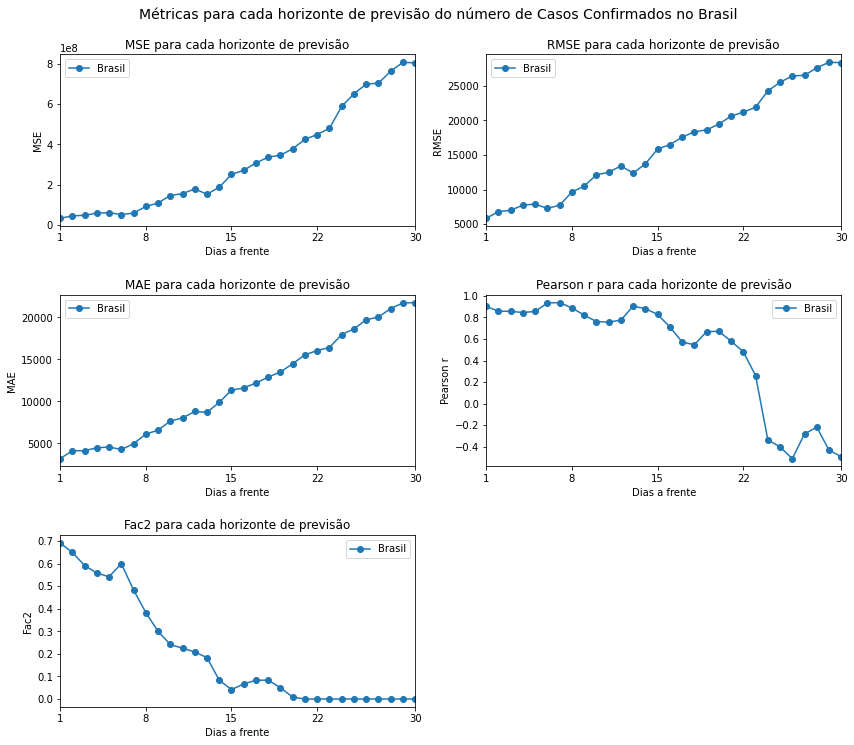

In [15]:
dict_brazil = {'Brasil': teste_selecao}
plot_metrics(dict_brazil, title='Métricas para cada horizonte de previsão do número de Casos Confirmados no Brasil')

/home/lucas.alves/.conda/envs/covid-web-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


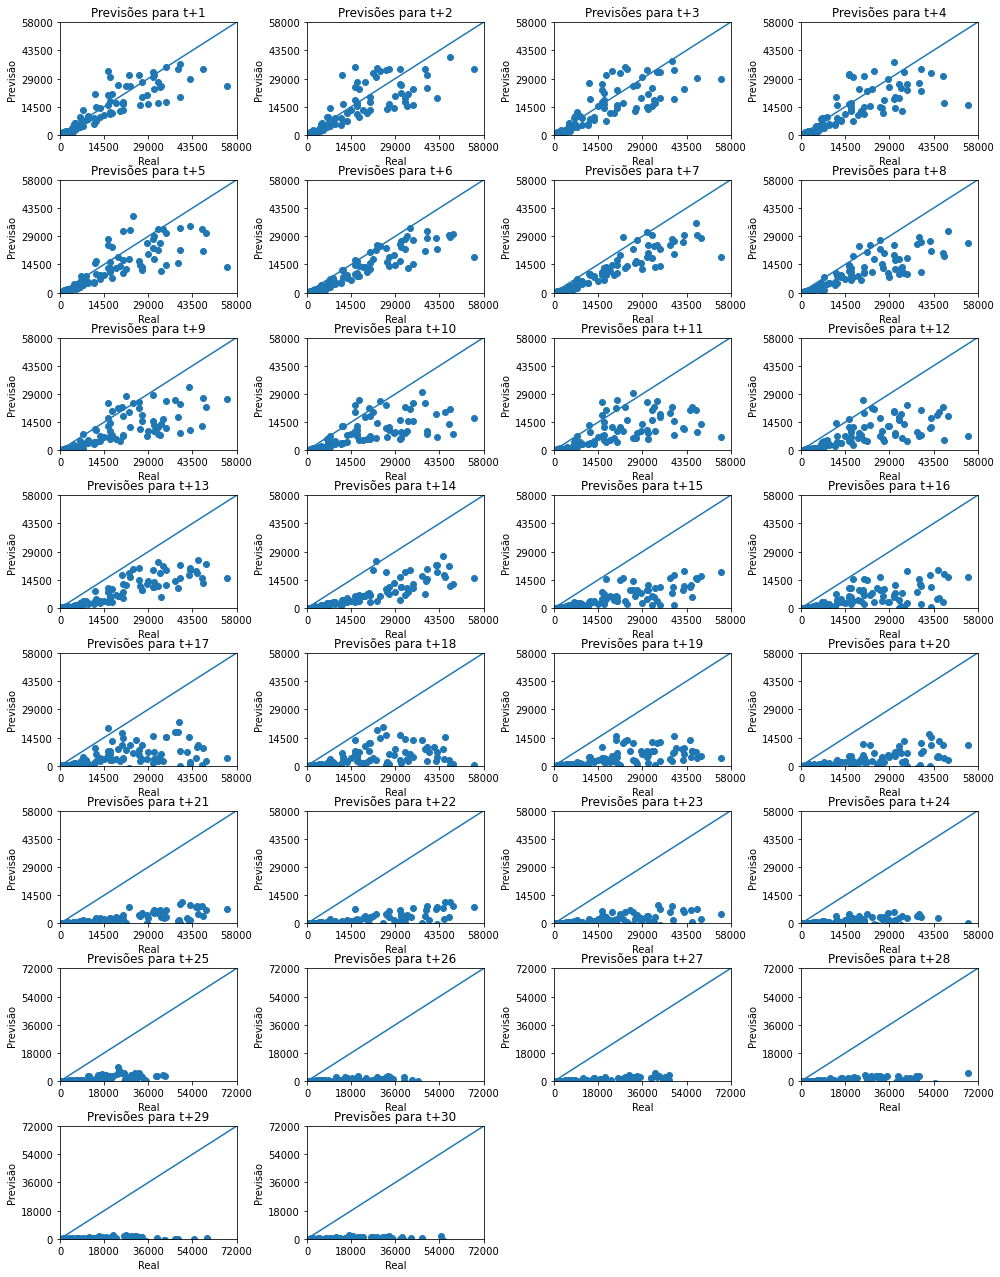

In [16]:
plot_scatter(observado, predicao, title='')

#### AVALIAÇÃO GRÁFICA DO MODELO POR HORIZONTE DE PREDIÇÃO

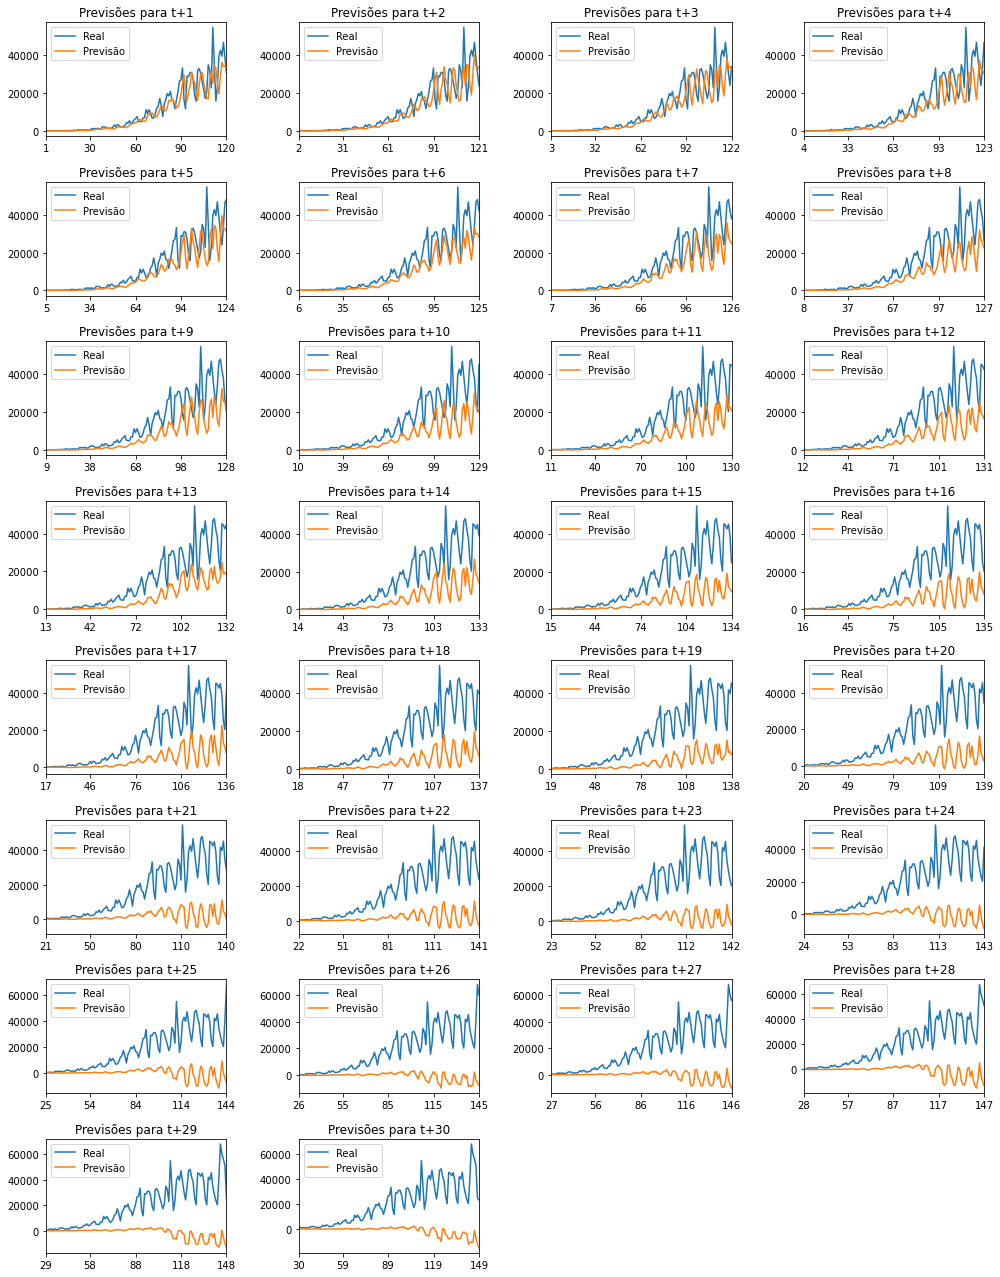

In [17]:
plot_samples(observado, predicao, title='')

### AVALIAÇÃO BAHIA

#### AVALIAÇÃO DAS PREDIÇÕES

#### MÉTRICAS DE AVALIAÇÃO PARA O PERÍODO 

In [18]:
predicao =  modelo.predict(teste_X_2) 
predicao = previsores_normalizado_2.inverse_transform(predicao)
observado = previsores_normalizado_2.inverse_transform(teste_Y_2)

predicao = pd.DataFrame(predicao)
observado = pd.DataFrame(observado)

teste_selecao = get_metrics(observado, predicao)
teste_selecao

,MSE,RMSE,MAE,Pearson r,Fac2
0,782612,884.653,424.986,0.711832,0.338843
1,809685,899.825,453.013,0.712801,0.338843
2,764088,874.121,438.978,0.741477,0.322314
3,879029,937.566,456.169,0.704992,0.380165
4,983110,991.519,492.474,0.667268,0.371901
5,983648,991.79,475.597,0.661307,0.38843
6,1.05618e+06,1027.71,557.665,0.681036,0.338843
7,1.16749e+06,1080.51,559.019,0.629205,0.305785
8,1.27594e+06,1129.58,598.731,0.635548,0.297521
9,1.20198e+06,1096.35,588.012,0.672945,0.280992


#### MÉTRICAS DE AVALIAÇÃO PARA O PERÍODO (ANÁLISE GRÁFICA)

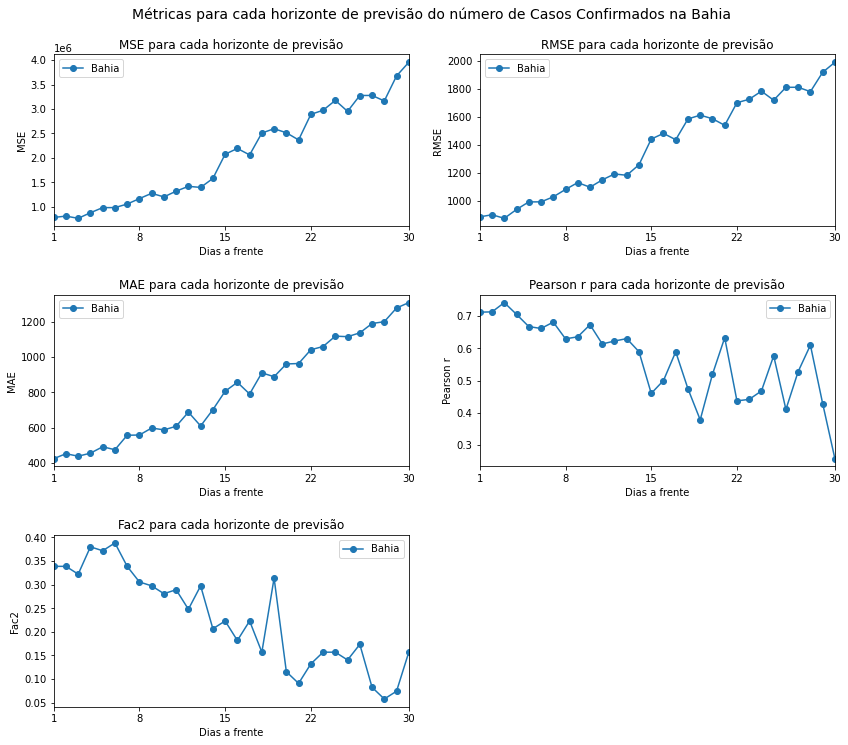

In [19]:
dict_brazil = {'Bahia': teste_selecao}
plot_metrics(dict_brazil, title='Métricas para cada horizonte de previsão do número de Casos Confirmados na Bahia')

/home/lucas.alves/.conda/envs/covid-web-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


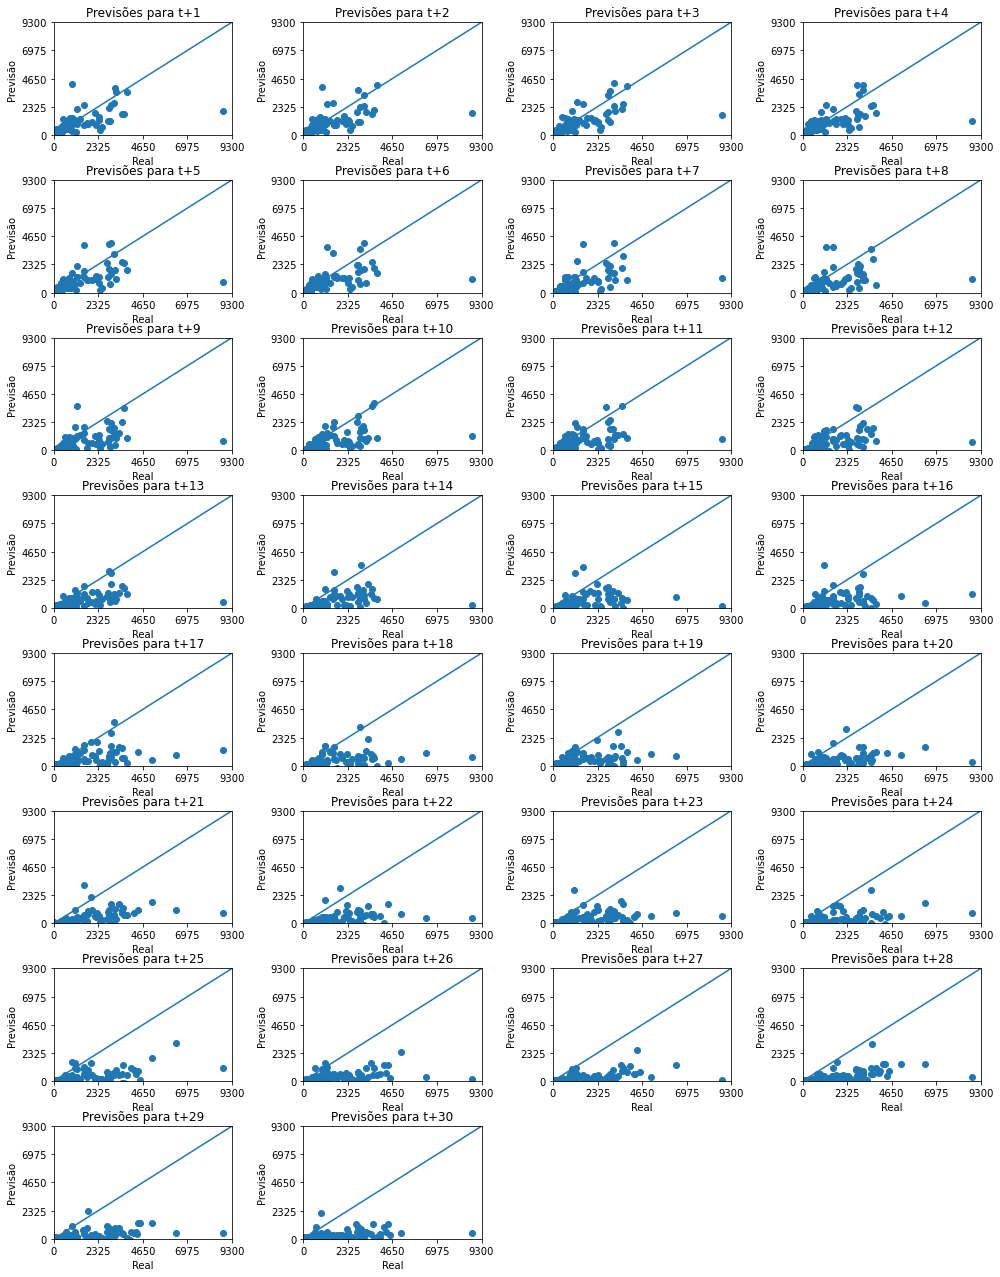

In [20]:
plot_scatter(observado, predicao, title='')

#### AVALIAÇÃO GRÁFICA DO MODELO POR HORIZONTE DE PREDIÇÃO

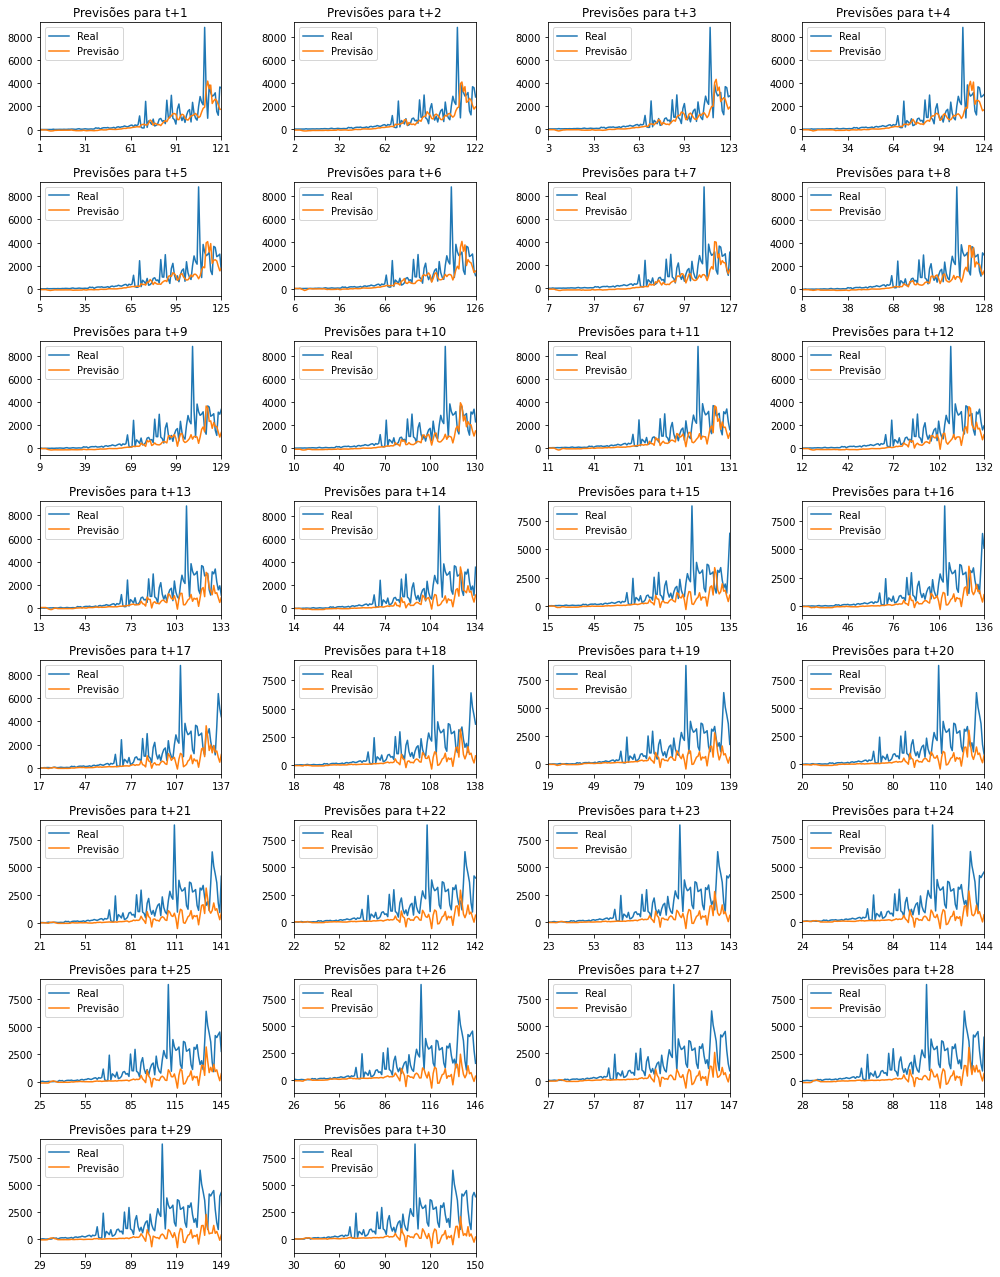

In [21]:
plot_samples(observado, predicao, title='')